# seq2seq (Sequence-to-Sequence)

In [79]:
# 모델 시각화 패키지 install
# !pip install pydot pydotplus graphviz

### Embedding Vector 준비

1. 영어 glove 임베딩(사전 학습) 사용 / 6B tokens, 400k vocab, uncased, 100d 
2. 한국어 임베딩 (초기 훈련)

In [80]:
# !gdown 1UK61mxiWzP1XPvJ53KXa7L7-ETbDYKgc

### 학습 데이터 준비

http://www.manythings.org/anki/

eng-kor 짝으로 이루어진 학습 데이터 

1. Encoder 입력 데이터 eng
    - encoder_input_eng 준비 `I love you`
2. Decoder 출력 데이터 kor
    - 학습용 teacher-forcing 모델
        - decoder_input_kor `<sos> 난 널 사랑해`
        - decoder_output_kor `난 널 사랑해 <eos>`
    - 추론용 모델

In [81]:
# <sos>(start of sentence) / <eos>(end of sentence) 

In [82]:
# !gdown 1sfIbATWOTpYiJZbl9NClZ9ZhbSvdR1Wz -O eng_kor.txt

In [83]:
eng_inputs = []     # 인코더 입력
kor_inputs = []     # 디코더 입력
kor_targets = []    # 디코더 출력

with open('eng_kor.txt', 'r', encoding='utf-8') as f:
    for line in f:
        eng, kor, _ = line.split('\t')

        kor_input = '<sos> ' + kor
        kor_target = kor + ' <eos>'

        eng_inputs.append(eng)
        kor_inputs.append(kor_input)
        kor_targets.append(kor_target)

len(eng_inputs), len(kor_inputs), len(kor_targets)

(5890, 5890, 5890)

In [84]:
print(eng_inputs[1000:1005])
print(kor_inputs[1000:1005])
print(kor_targets[1000:1005])


["I'm just sleepy.", "I'm not sulking.", "I'm on the list.", 'Is Tom with you?', 'Is anybody home?']
['<sos> 나 졸려.', '<sos> 나 삐친 거 아니야.', '<sos> 나는 명단에 있다.', '<sos> 톰이랑 같이 있어?', '<sos> 누구 집에 있어요?']
['나 졸려. <eos>', '나 삐친 거 아니야. <eos>', '나는 명단에 있다. <eos>', '톰이랑 같이 있어? <eos>', '누구 집에 있어요? <eos>']


### 토큰화
- 인코더(영어) : 영문 토커나이저
- 디코더(한글) : 국문 토커나이저

In [85]:
VOCAB_SIZE = 10000

### 영문 토큰화

In [86]:
from tensorflow.keras.preprocessing.text import Tokenizer

eng_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<oov>')
eng_tokenizer.fit_on_texts(eng_inputs)
eng_inputs_seq = eng_tokenizer.texts_to_sequences(eng_inputs)

eng_inputs_seq[1000:1005]

[[16, 114, 487],
 [16, 32, 1915],
 [16, 49, 6, 1916],
 [7, 3, 45, 5],
 [7, 367, 89]]

In [87]:
for seq in eng_inputs_seq[1000:1005]:
    print([eng_tokenizer.index_word[index] for index in seq])

["i'm", 'just', 'sleepy']
["i'm", 'not', 'sulking']
["i'm", 'on', 'the', 'list']
['is', 'tom', 'with', 'you']
['is', 'anybody', 'home']


In [88]:
eng_num_words = min(VOCAB_SIZE, len(eng_tokenizer.word_index))  # 실제 영어단어의 개수

In [ ]:
eng_max_len = max([len(seq) for seq in eng_inputs_seq])  # 영어 문장 최대 길이

### 국문 토큰화

In [90]:
# filters='' 필터사용안함 (기본값: filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
kor_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<oov>', filters='')  # filters : 제거할 문자를 지정하는 옵션
kor_tokenizer.fit_on_texts(kor_inputs + kor_targets)  # <sos> <eos> 포함 

kor_inputs_seq = kor_tokenizer.texts_to_sequences(kor_inputs)
kor_targets_seq = kor_tokenizer.texts_to_sequences(kor_targets)

kor_inputs_seq[1000:1001], kor_targets_seq[1000:1001]

([[2, 81, 1655]], [[81, 1655, 3]])

In [91]:
kor_tokenizer.index_word

{1: '<oov>',
 2: '<sos>',
 3: '<eos>',
 4: '톰은',
 5: '나는',
 6: '톰이',
 7: '난',
 8: '있어.',
 9: '그',
 10: '내가',
 11: '수',
 12: '이',
 13: '내',
 14: '그는',
 15: '있다.',
 16: '있어?',
 17: '네가',
 18: '것',
 19: '우리는',
 20: '것을',
 21: '더',
 22: '왜',
 23: '할',
 24: '너무',
 25: '너',
 26: '좀',
 27: '안',
 28: '네',
 29: '정말',
 30: '거야.',
 31: '않아.',
 32: '우리',
 33: '한',
 34: '없어.',
 35: '같아.',
 36: '그녀는',
 37: '알고',
 38: '걸',
 39: '것이다.',
 40: '프랑스어를',
 41: '있는',
 42: '없다.',
 43: '줄',
 44: '한다.',
 45: '않는다.',
 46: '이건',
 47: '우린',
 48: '잘',
 49: '가장',
 50: '해.',
 51: '너는',
 52: '톰을',
 53: '하고',
 54: '적',
 55: '집에',
 56: '사람은',
 57: '했다.',
 58: '그걸',
 59: '아무도',
 60: '여기',
 61: '있을',
 62: '건',
 63: '날',
 64: '넌',
 65: '것은',
 66: '그렇게',
 67: '메리가',
 68: '톰과',
 69: '했어.',
 70: '지금',
 71: '않았다.',
 72: '톰의',
 73: '오늘',
 74: '무슨',
 75: '얼마나',
 76: '그게',
 77: '좋은',
 78: '것이',
 79: '아주',
 80: '그의',
 81: '나',
 82: '그것을',
 83: '하지',
 84: '그건',
 85: '어떻게',
 86: '있었어.',
 87: '적이',
 88: '못',
 89: '우리가',
 90: '그가',
 

In [92]:
kor_num_words = min(VOCAB_SIZE, len(kor_tokenizer.index_word))  # 실제 한국어 단어의 개수

In [93]:
kor_max_len = max(len(seq) for seq in kor_inputs_seq)

### 패딩처리
- 인코더 padding = 'pre'
- 디코더 padding = 'post'

In [94]:
# 인코더 앞의 내용은 점점 희미해지기 때문에 pre로 앞에 패딩을 해주고, 디코더는 앞에 0으로 채워져있으면 의미가 없기 때문에 자리만 채워주게끔 post로 뒤에 패딩을 해준다.

In [95]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

eng_inputs_padded = pad_sequences(eng_inputs_seq, maxlen=eng_max_len, padding='pre') # 인코더 입력
kor_inputs_padded = pad_sequences(kor_inputs_seq, maxlen=kor_max_len, padding='post') # 디코더 입력
kor_targets_padded = pad_sequences(kor_targets_seq, maxlen=kor_max_len, padding='post') # 디코더 출력력

eng_inputs_padded.shape, kor_inputs_padded.shape, kor_targets_padded.shape

((5890, 101), (5890, 90), (5890, 90))

### 모델 학습

`encoder + decoder(teacher_forcing)` 구조의 모델을 생성 및 학습
- 영문 Embedding Layer는 glove.6B.100d의 사전 학습 모델 사용

##### Embedding Layer

In [96]:
with open('./glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for i, vects in enumerate(f):
        print(vects)
        if i == 5:
            break

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062

, -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81665 0.14172 0.21939 0.58505 -0.52158

In [97]:
import numpy as np

def make_embedding_matrix(num_words, embedding_dim, tokenizer, file_path):
    embedding_matrix = np.zeros((num_words + 1, embedding_dim))

    pretrained_embedding = {}

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            word, *vects = line.split()
            vects = np.array(vects, dtype=np.float32)
            pretrained_embedding[word] = vects

        for word, index in tokenizer.word_index.items():
            vects_ = pretrained_embedding.get(word)
            if vects_ is not None:
                embedding_matrix[index] = vects_
        
        return embedding_matrix

In [98]:
EMBEDDING_DIM = 100 # GLoVe 벡터 차원

# 인코더의 임베딩 행렬 생성성
en_embedding_matrix = make_embedding_matrix(
    eng_num_words,
    EMBEDDING_DIM,
    eng_tokenizer,
    'glove.6B.100d.txt'
)

en_embedding_matrix.shape

(3201, 100)

In [99]:
eng_word_index = ['<pad>'] + list(eng_tokenizer.index_word.values())
eng_word_index

['<pad>',
 '<oov>',
 'i',
 'tom',
 'to',
 'you',
 'the',
 'is',
 'a',
 'that',
 'do',
 'in',
 'this',
 'was',
 'have',
 'he',
 "i'm",
 'my',
 'are',
 'of',
 "don't",
 'it',
 'me',
 'be',
 'your',
 'like',
 'for',
 'what',
 'want',
 'think',
 'we',
 'know',
 'not',
 'mary',
 'his',
 'there',
 'how',
 'can',
 'french',
 'and',
 'very',
 'has',
 "it's",
 'at',
 'go',
 'with',
 'she',
 'did',
 "didn't",
 'on',
 'here',
 'why',
 'going',
 'been',
 'all',
 'no',
 'as',
 'really',
 'help',
 'please',
 'time',
 "can't",
 'they',
 'will',
 'him',
 "isn't",
 'one',
 "you're",
 'if',
 'about',
 'good',
 "that's",
 'who',
 'too',
 "doesn't",
 'up',
 'had',
 'were',
 'where',
 'would',
 'from',
 "tom's",
 'said',
 'need',
 'something',
 'when',
 'us',
 'tell',
 'never',
 'home',
 'now',
 'still',
 'more',
 'school',
 'so',
 'an',
 'should',
 'come',
 'than',
 'some',
 'sorry',
 'but',
 'ever',
 'get',
 'work',
 'out',
 "i'll",
 "i've",
 'three',
 'by',
 'boston',
 'take',
 'keep',
 'stop',
 'just',

In [100]:
import pandas as pd

pd.DataFrame(en_embedding_matrix, index=eng_word_index)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
<pad>,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
<oov>,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
i,-0.046539,0.619660,0.56647,-0.465840,-1.189000,0.445990,0.066035,0.319100,0.146790,-0.22119,...,-0.323430,-0.431210,0.41392,0.283740,-0.709310,0.150030,-0.215400,-0.376160,-0.032502,0.806200
tom,-0.583880,-0.469400,0.16855,-1.670300,-0.116010,0.048738,-0.342010,-0.376910,-0.953080,-0.88260,...,0.264290,0.337860,0.35791,0.549010,0.006725,0.281580,0.343730,0.137040,0.089572,-0.542770
to,-0.189700,0.050024,0.19084,-0.049184,-0.089737,0.210060,-0.549520,0.098377,-0.201350,0.34241,...,-0.131340,0.058617,-0.31869,-0.614190,-0.623930,-0.415480,-0.038175,-0.398040,0.476470,-0.159830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
whom,0.341680,0.545720,-0.15683,-0.205450,-0.199470,0.389270,-0.017266,-0.244750,0.124760,-0.34392,...,0.142210,-0.556420,0.45764,-0.243960,-1.146800,0.330140,-0.900430,-0.014213,0.161420,-0.444830
intimately,-0.416930,0.131300,0.50615,0.034870,0.255630,0.409070,0.234080,-0.574340,0.293270,0.14061,...,-0.636420,0.066336,-0.44926,-1.350100,0.381640,-0.051961,-0.425590,-0.667450,0.009747,0.061855
millions,0.622040,1.063600,0.13146,-0.203880,0.555570,0.443570,-0.524210,0.040587,0.470640,-0.53788,...,-0.063191,-0.111260,0.66609,-0.972050,-0.558910,-0.837910,-0.147160,0.862920,0.302910,-0.225640
inhabit,-0.927750,0.738860,0.69884,0.138580,0.020592,0.521490,-0.541050,0.501790,0.206630,-0.51982,...,0.491800,-0.235440,0.48243,-0.714400,-0.378190,0.271660,-1.243600,-0.288030,0.065840,0.053163


#### 인코더 모델

In [101]:
# from tensorflow.keras import layers, models

# LATENT_DIM = 512 # LSTM의 은닉층 수 

# encoder_inputs = layers.Input(shape=(eng_max_len,))  # 인코더 입력
# en_embedding_layer = layers.Embedding(
#     eng_num_words + 1,
#     EMBEDDING_DIM,
#     weights=[en_embedding_matrix]
# )  # 인코더 임베딩 레이어
# x = en_embedding_layer(encoder_inputs)  # 인코더 임베딩 레이어
# encoder_outputs, h, c = layers.LSTM(LATENT_DIM, return_state=True)(x)  # 인코더 LSTM 레이어 (출력, 은닉상태, 셀상태)
# encoder_states = [h, c]  # 인코더 상태

# encoder_model = models.Model(inputs=encoder_inputs, outputs=encoder_states)  # 인코더 모델  (h, c를 디코더에 넘겨주기 위해서)

# encoder_model.summary()

In [102]:
from tensorflow.keras import layers, models

LATENT_DIM = 512    # LSTM의 은닉층 수 

encoder_inputs = layers.Input(shape=(eng_max_len,))
en_embedding_layer = layers.Embedding(eng_num_words + 1, EMBEDDING_DIM, weights=[en_embedding_matrix])
x = en_embedding_layer(encoder_inputs)
encoder_outputs, h, c = layers.LSTM(LATENT_DIM, return_state=True)(x)
encoder_states = [h, c]

encoder_model = models.Model(inputs=encoder_inputs, outputs=encoder_states)

encoder_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 101, 100)       │       320,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ [(None, 512), (None,   │     1,255,424 │
│                                 │ 512), (None, 512)]     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,575,524 (6.01 MB)

 Trainable params: 1,575,524 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

#### 디코더 모델 (Teacher-forcing)

In [103]:
# decoder_inputs = layers.Input(shape=(kor_max_len,))  # 디코더 입력
# ko_embedding_layer = layers.Embedding(kor_num_words + 1, EMBEDDING_DIM)  # 디코더 임베딩 레이어 / padding + 1
# x = ko_embedding_layer(decoder_inputs)
# decoder_lstm = layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True)
# x, h, c = decoder_lstm(x, initial_state=encoder_states) # 인코더의 은닉상태와 셀 상태를 디코더에 넘겨줌 

# decoder_dense = layers.Dense(kor_num_words + 1, activation='softmax')
# decoder_outputs = decoder_dense(x)

# decoder_teacher_forcing_model = models.Model(
#     inputs=[encoder_inputs, decoder_inputs],
#     outputs=decoder_outputs
# )

# decoder_teacher_forcing_model.summary()

decoder_inputs = layers.Input(shape=(kor_max_len,))
ko_embedding_layer = layers.Embedding(kor_num_words + 1, EMBEDDING_DIM)
x = ko_embedding_layer(decoder_inputs)
decoder_lstm = layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, h, c = decoder_lstm(x, initial_state=encoder_states)

decoder_dense = layers.Dense(kor_num_words + 1, activation='softmax')
decoder_outputs = decoder_dense(x)

decoder_teacher_forcing_model = models.Model(
    inputs=[encoder_inputs, decoder_inputs],
    outputs=decoder_outputs
)

decoder_teacher_forcing_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 101)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 90)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 101, 100)  │    320,100 │ input_layer_14[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 90, 100)   │    828,900 │ input_layer_15[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 512),     │  1,255,424 │ embedding_5[0][0] │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, 90, 512), │  1,255,424 │ embedding_6[0][0… │
│                     │ (None, 512),      │            │ lstm_5[0][1],     │
│                     │ (None, 512)]      │            │ lstm_5[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 90, 8289)  │  4,252,257 │ lstm_6[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,912,105 (30.18 MB)

 Trainable params: 7,912,105 (30.18 MB)

 Non-trainable params: 0 (0.00 B)

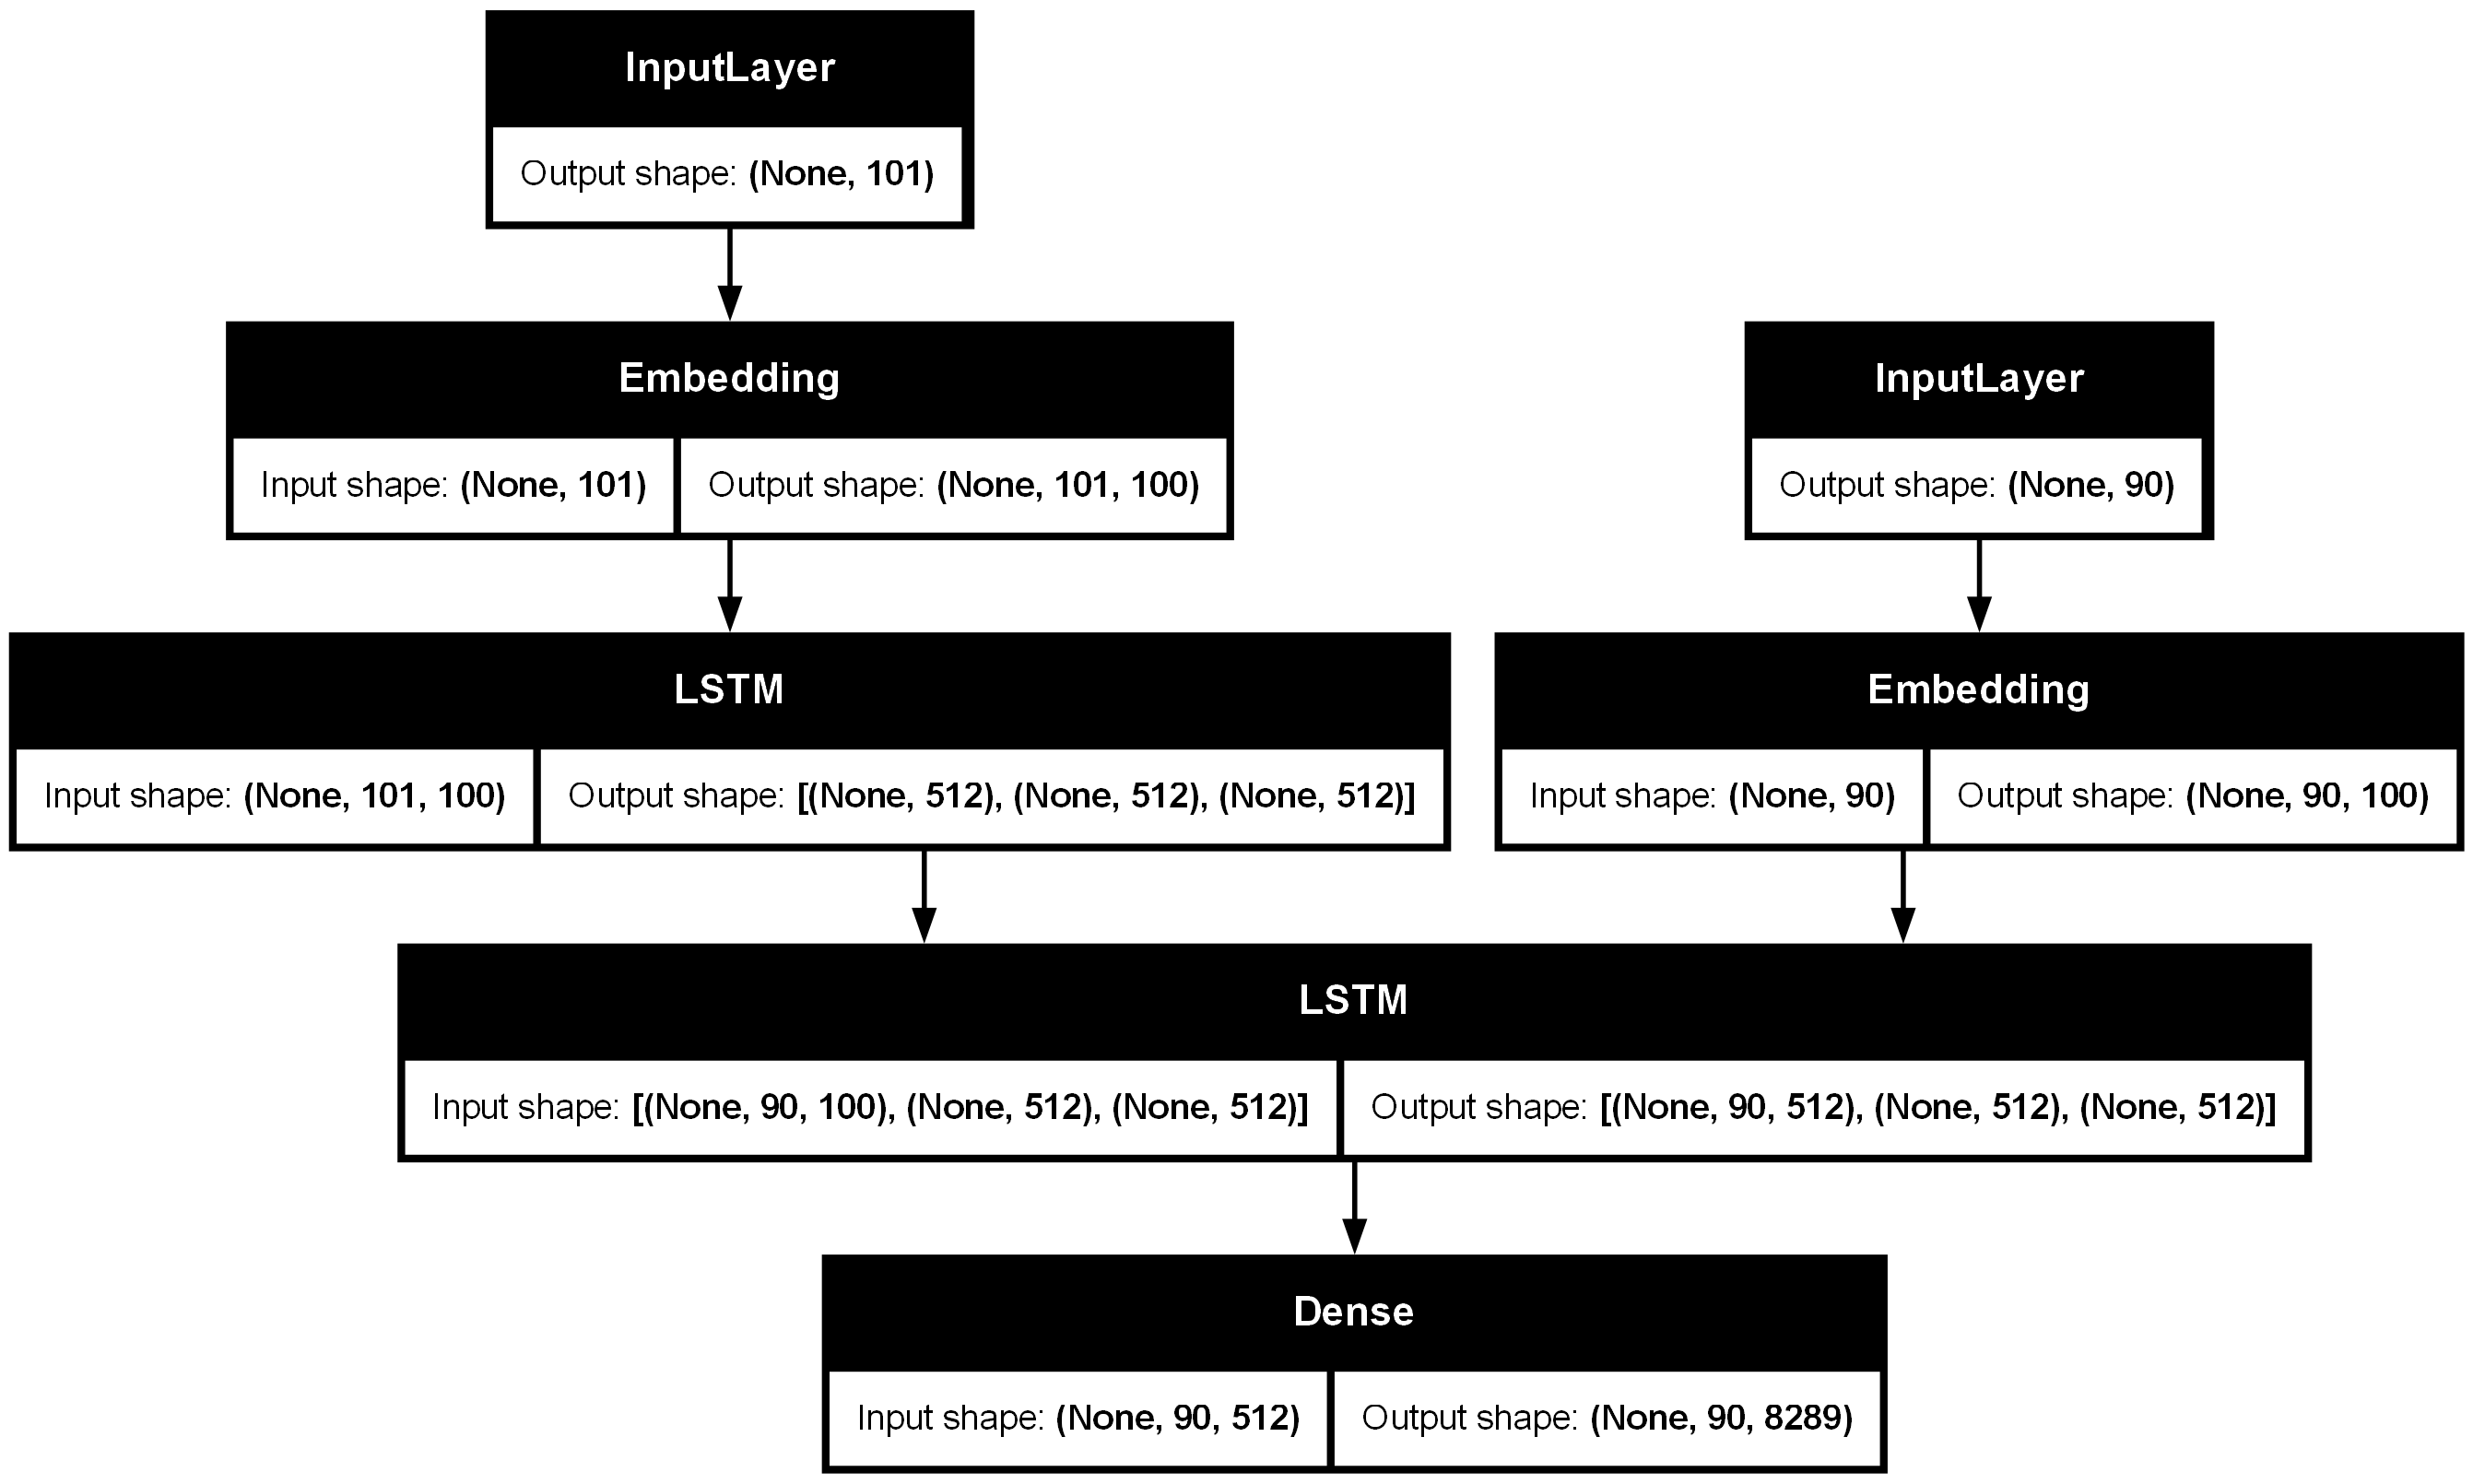

In [104]:
# teacher-forcing model 시각화
from tensorflow.keras.utils import plot_model

plot_model(decoder_teacher_forcing_model, show_shapes=True)

##### 모델 학습

In [105]:
decoder_teacher_forcing_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = decoder_teacher_forcing_model.fit(
    [eng_inputs_padded, kor_inputs_padded],
    kor_targets_padded,
    batch_size=64,
    epochs=70,
    validation_split=0.2
)

Epoch 1/70
74/74 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.8868 - loss: 2.5773 - val_accuracy: 0.9247 - val_loss: 0.6733
Epoch 2/70
74/74 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9597 - loss: 0.3364 - val_accuracy: 0.9308 - val_loss: 0.6294
Epoch 3/70
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9610 - loss: 0.3148

KeyboardInterrupt: 

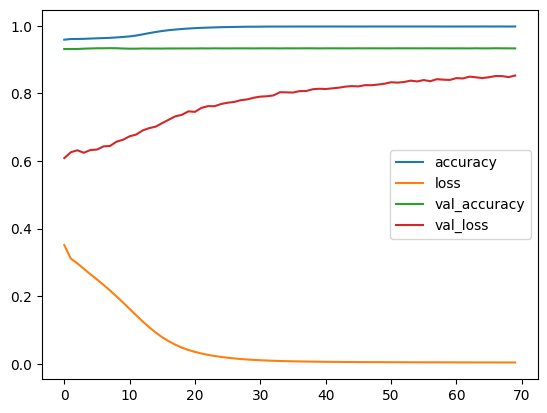

In [ ]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot()
plt.show()

In [107]:
# 모델 저장
decoder_teacher_forcing_model.save('decoder_teacher_forcing_model.keras')

In [108]:
# 모델 로드
from tensorflow.keras.models import load_model
decoder_teacher_forcing_model_ = load_model('decoder_teacher_forcing_model.keras')

### 모델 추론
`encoder + decoder(inference)` 구조의 모델로 추론

##### 디코더 추론 모델

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 1, 100)    │    828,900 │ input_layer_18[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, 1, 512),  │  1,255,424 │ embedding_6[1][0… │
│                     │ (None, 512),      │            │ input_layer_16[0… │
│                     │ (None, 512)]      │            │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 8289)   │  4,252,257 │ lstm_6[1][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,336,581 (24.17 MB)

 Trainable params: 6,336,581 (24.17 MB)

 Non-trainable params: 0 (0.00 B)

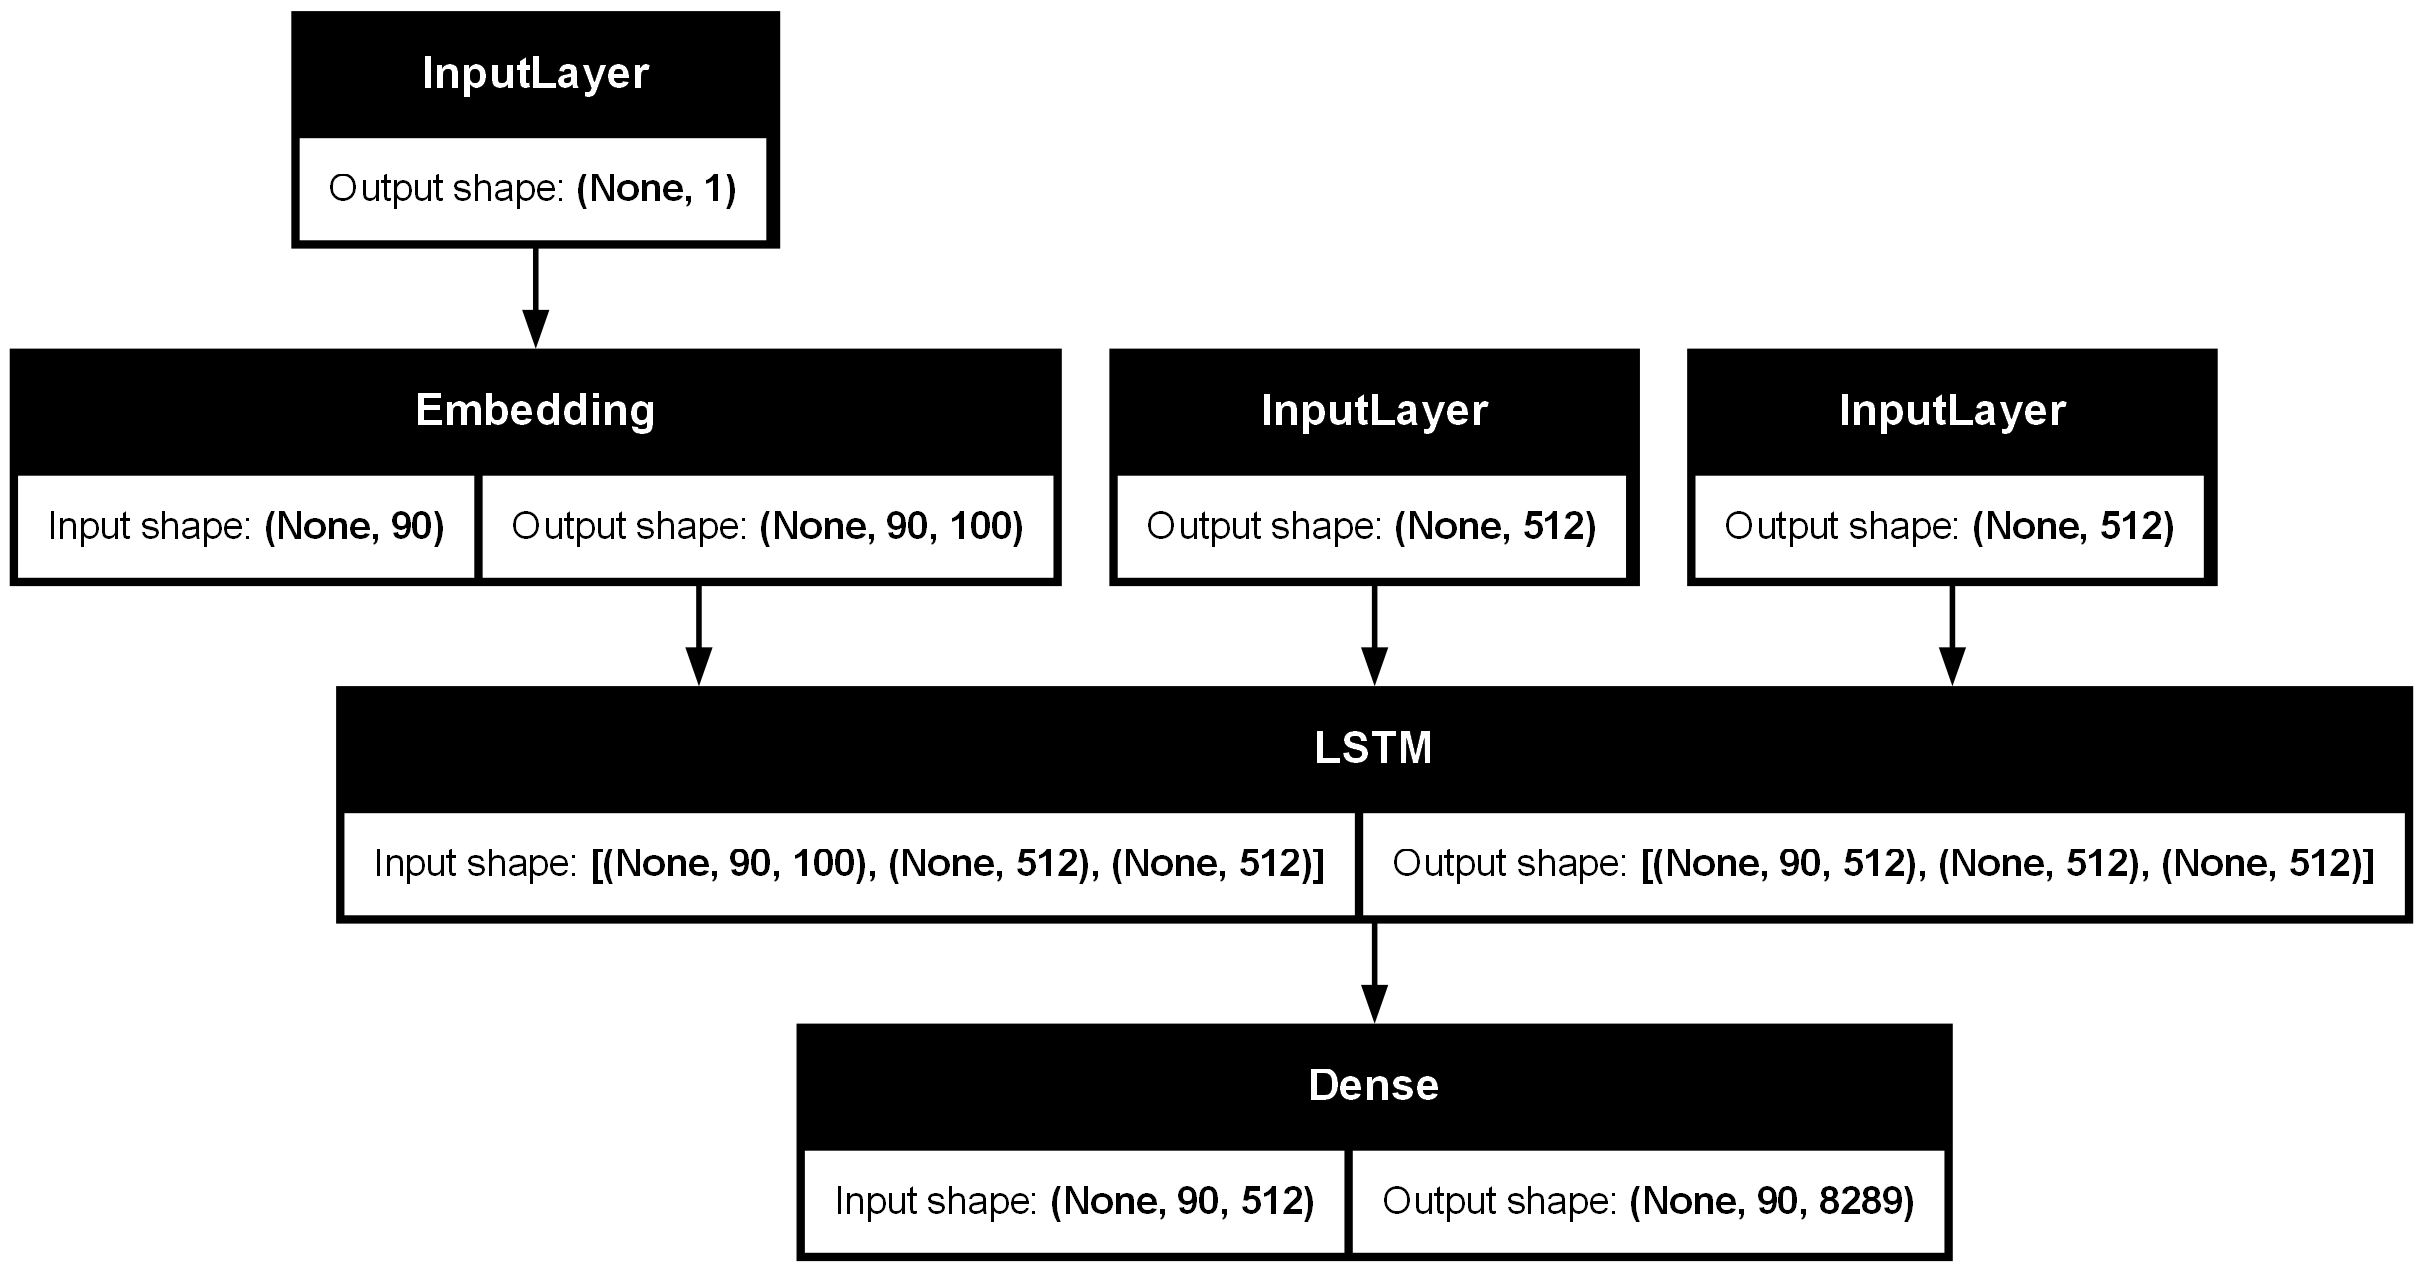

In [109]:
# 입력 states (이전 timestep의 hidden state, cell state)
decoder_hidden_state = layers.Input(shape=(LATENT_DIM,))
decoder_cell_state = layers.Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_hidden_state, decoder_cell_state]      # 

# 토큰 입력 (이전 timestep의 output)
decoder_single_input = layers.Input(shape=(1,))

# 학습된 임베딩
x = ko_embedding_layer(decoder_single_input)

# 학습된 LSTM
x, h, c = decoder_lstm(x, initial_state=decoder_states_inputs)
decoder_states = [h, c]

# 학습된 dense
decoder_outputs_ = decoder_dense(x)

decoder_inference_model = models.Model(
    inputs=[decoder_single_input] + decoder_states_inputs,
    outputs=[decoder_outputs_] + decoder_states
)

decoder_inference_model.summary()
plot_model(decoder_inference_model, show_shapes=True)

##### 추론 함수

In [110]:
def translate(input_seq):
    # 인코더에 input_seq 통과(추론) -> hidden_state, cell_state만 반환 
    encoder_states_value = encoder_model.predict(input_seq)
    decoder_states_value = encoder_states_value # 디코더의 상태를 인코더의 상태로 초기화 (초기값)

    # 디코더
    # 1. <sos><eos> 
    sos_index = kor_tokenizer.word_index['<sos>']
    eos_index = kor_tokenizer.word_index['<eos>']

    # 2. target_seq 준비 (디코터 출력)
    target_seq = np.zeros((1, 1))   # 배치사이즈 1, 단어 1개 (shape을 맞추기 위해)
    target_seq[0, 0] = sos_index

    # 3. 순차적으로 디코딩(= 번역)
    output_sentence = []

    for _ in range(kor_max_len):
        output_tokens, h, c = decoder_inference_model.predict([target_seq] + decoder_states_value)  # 디코더 예측

        pred_proba = output_tokens[0, 0, :]   # 예측된 단어 확률 분포 
        pred_index = np.argmax(pred_proba) # 예측된 단어 인덱스

        if pred_index == eos_index:
            break
        

        if pred_index > 0:
            word = kor_tokenizer.index_word[pred_index]
            output_sentence.append(word)

        target_seq[0, 0] = pred_index  # 예측된 단어 인덱스를 target_seq에 넣어줌
        decoder_states_value = [h, c]   # 디코더 상태 업데이트 

    return " ".join(output_sentence)  # 예측된 단어를 공백으로 연결하여 하나의 문자열로 만들어 반환 


In [112]:
print(eng_inputs[:1])

input_seq = eng_inputs_padded[:1]
output_sent = translate(input_seq)

print(output_sent)

['Go.']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



In [ ]:
for _ in range(5):
    idx = np.random.choice(len(eng_inputs_padded))
    input_seq = eng_inputs_padded[idx:idx+1]
    output_sent = translate(input_seq)  
    display("입력 영문:", eng_inputs[idx])
    display("학습한 국문:", kor_inputs[idx])
    display("추론한 국문:", output_sent)
    display()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

'입력 영문:'

"Let's hear the rest of the story."

'학습한 국문:'

'<sos> 이야기를 마저 들어 봅시다.'

'추론한 국문:'

'건강하다니까. 건강하다니까. 건강하다니까. 아끼기 아끼기 아끼기 안한거야? 넘치고 딱 딱 딱 딱 딱 딱 땄다. 크리스마스 크리스마스 메스암페타민 긍정적이야. 사야겠어. 침대 싫어했다. 싫어했다. 집인 집인 저거 책들을 앉았다. 해변이 호주에 출석한 신청을 좋아하지 애써하지 유괴 기차역까지 원어민 울었는지를 안다는 보이지 풍성하다. 지불할 후회한다. 번째 잡아. 오빠가 되었다더라. 아는 아는 아는 부르고 일요일에 쉬고 유기농 유기농 유기농 그녀에게는 자폐증과 그녀에게는 다윈의 과학을 이상한 당신 점점 살고 절대로! 전문 문 두려워할까? 되나요? 달성했다. 달성했다. 지낸 주인이다. 톰의 흉하게 흉하게 재미있는 던져서 무기이다. 싸우는 해고당했다. 무기이다. 알아듣겠어. 생각해요? 펼쳐라. 도서관에 죽었어 내년까지 경찰은'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

'입력 영문:'

'You look tired, so you should go to bed early.'

'학습한 국문:'

'<sos> 피곤해 보이니까 일찍 자는 것이 좋겠다.'

'추론한 국문:'

'건강하다니까. 건강하다니까. 안아주었다. 안아주었다. 안아주었다. 안아주었다. 안아주었다. 안아주었다. 과학의 과학의 과학의 과학의 과학의 예정이다. 알아낼 알아낼 알아낼 알아낼 방침에 의미를 빨갛다. 이상하네! 접수했다. 접수했다. 그저께였다. 페이스북 페이스북 충격이야. 배웅하러 배웅하러 하면 하면 병원으로 병원으로 친구에게 생각하니? 좋아보이지 소식이 소식이 뭐든 뭐든 아프리카에서 개와 아침을 공부하고 공부하고 해결해야 아빠에 깊이 와요. 가능한 늙고 가자. 사니? 용서하리라고는 진심이야! 탄다. 열차를 피 피 부엌에 부엌에 이해한거야 북한은 월드컵이 싶어. 토요일마다 1단이다. 마침내 죽기 죽기 늦었나요? 맑다. 늦었나요? 맑다. 성과가 하얗다. 취직에 허튼 허튼 쳐. 오늘날 멈췄다. 3일 반인륜적인 저스틴 디스크를 만들었어. 관두는 교회는'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

'입력 영문:'

'An accident has occurred.'

'학습한 국문:'

'<sos> 사고가 벌어졌다.'

'추론한 국문:'

'안아주었다. 안아주었다. 안아주었다. 안아주었다. 안아주었다. 전염병 해줬어. 혼란스럽다. 음식이 음식이 수출 오른다. 무리하지 톰보다 따라와. 바베큐 따라와. 멋있어요. 가? 가? 소식이 소식이 뭐든 왔었을 왔었을 니가 니가 말한다면 들어보자. 들어보자. 시골에 어딜 아이스크림을 어딜 커피 봤던 봤던 미안하다고 안에서 팔지 설탕은 들고 교사다. 배우고자했는지 추천하셨다. 사람한테 청년들에게 유명한 머물러 공짜에요. 의무는 마련이다. 8시간 배우도록 질문해도 진실을 연습해. 돈은 흥미를 식물에 밤은 국적은 열어둬. 진실을 위한 묻혀 종양이 지냈나요? 지기 참가자는 눈처럼 눈처럼 않는게 그냥 강아지 유기농 유기농 방학 일하던 일하던 일하던 톰한텐 톰한텐 톰한텐 선수야. 정확했어. 책입니까? 책입니까? 허리가 로프를'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

'입력 영문:'

'What scares you most?'

'학습한 국문:'

'<sos> 뭐가 제일 무서워?'

'추론한 국문:'

'건강하다니까. 건강하다니까. 건강하다니까. 아끼기 아끼기 아끼기 아끼기 거기 혼란스럽다. 산 산 문자 아팠다고 아팠다고 양보다 꿨어. 받아들여라. 가르쳤어. 사랑하는 일으키나요? 않으면 날 주문했다. 나아졌다. 1분만 영어로 영어로 주문했다. 영어로 경기에서 샀어. 정해. 오랫동안에 생각이다. 말이나 알려지지 대답하길 행복한 행복한 행복한 정확하게 행복한 톰이죠? 두통은 집은 가방에 배웅하러 나에게 과학과 혼나고 기차로 기차로 신의 당신이다. 말아줘. 누군가를 근무한다. 아니라고 들려주었다. 파괴되었다. 책은 참 짐작도 짐작도 짐작도 스스로를 스스로를 스스로를 가든 가든 책이 모임에 모임에 모임에 취해본 취해본 안에서 것이다. 가게는 가게는 반대의 가게는 동물에게 된 집을 집을 들어가는 널 널 저에게는'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

'입력 영문:'

'Go there.'

'학습한 국문:'

'<sos> 거기로 가.'

'추론한 국문:'

'아끼기 아끼기 아끼기 아끼기 부담스러워? 부담스러워? 부담스러워? 부담스러워? 부담스러워? 가짜같진 슬프다니! 캐물어. 약속할게. 노력했어. 캐물어. 놀 놀 중독자야. 중독자야. 기타좀 박스와 깊이 네게 저한테 찾았다. 할일이 도와도 쉬었어. 반이었다. 수천명의 톰이 간 간 샐러드 나간다. 안그러면 대화해도 보물이 변호사야. 결혼했다면 고양이를 빨라. 읽는 솔로야? 만족시키기가 보냈어. 싫어하는 보냈어. 중요한 터졌을 터졌을 어렵지 어렵지 없어 어렵지 행동하려고 후 수상 명의 명의 지냈다. 지냈다. 택시를 벌써 택시를 매력적일 정확하게 정확하게 자동차를 메스암페타민 작별인사해. 10월부터 폐를 폐를 카메라는 카메라는 즐거운 부르지 부르지 부르지 가족 드레스가 해줬으면 아티스트다. 들어가기 좋겠어. 가설이 영화관에 영화관에 행복하다.'

In [ ]:
def translate_eng2kor(eng_text):
    # 입력 데이터 전처리
    input_seq = eng_tokenizer.texts_to_sequences(eng_text)
    input_seq = pad_sequences(input_seq, maxlen=eng_max_len)
    return translate(input_seq) # 추론 함수 호출

eng_texts = [
    "My lips are red.",
    "French is interesting.",
    "I like bus",
    "Let\'s study",
    "I ate sandwich"
]

In [ ]:
for eng_text in eng_texts:
    kor_text = translate_eng2kor([eng_text])
    display(eng_text, kor_text)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

'My lips are red.'

'건강하다니까. 건강하다니까. 건강하다니까. 건강하다니까. 건강하다니까. 건강하다니까. 염소야? 뭐하고 몇시에 몇시에 건강하다니까. 뉴욕에 개의 개의 빠진 개의 조금이나마 반복해야 졸려해? 디스크를 누나는 졸려해? 디스크를 디스크를 1-800-446-2581을 선교사로서 들어가면 들어가면 20분이나 지냈나요? 있죠? 수도다. 지각했다. 수도다. 두 먹이 공부할까요? 후 후 추락했다. 되풀이하게 사람을 사람을 접수했다. 접수했다. 접수했다. 그저께였다. 읽어라. 애묘인이야? 30분씩 30분씩 아는가? 아는가? 걸려. 종교와 졌어. 졌어. 보지 졌어. 보지 파티에 밀치며 밀치며 저거보다 뺄 더는 우리에겐 우리에겐 별난 뜻인지 기뻐요. 별난 불러주실 남는 남는 대화하지 대화하지 금발로 보내줬으면 너희 핸드백 가방에 모임에 모임에 모임에 취해본 불렀어야 샀어. 공항이야? 공항이야?'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

'French is interesting.'

'못했었어요. 못했었어요. 못했었어요. 아끼기 아끼기 아끼기 거기 아끼기 거기 스웨덴의 경향이 경향이 배우도록 배우도록 못했었어요. 질문해도 부족은 유혹하는 덥네. 속이셨죠? 은행은 은행은 연설을 의자에 허상이야. 생일이 동감이에요. 직업은 구조됐다. 시계는 구조됐다. 참석 취직 취직 날리곤 피곤해보인다고 도망을 1/6배야. 내가 계산할 티브이 늙고 있대. 프랑스의 모래로 멈춰야 나더러 식물이 지각해서 면허 나더러 돌아갔었다. 불명이야. 전환점인 규칙을 나랑 나랑 스푸트니크는 같네. 먹으세요. 어디서부터 베이컨의 기후가 일해. 떨어졌다. 칠 향해 위해 명령했다. 동등해. 장애로 장애로 장애로 주기를 동등해. 핸드폰이 핸드폰이 볼펜이 바꿨다. 전쟁 카누를 카누를 설치하는 재미있는 좋아해본 이마에 미워한다. 덥다! 겪더라. 훔쳤어.'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

'I like bus'

'건강하다니까. 건강하다니까. 건강하다니까. 건강하다니까. 아끼기 아끼기 건강하다니까. 돌아와서 돌아와서 어머니는 과학의 속이셨죠? 못했었어요. 오른다. 바꿀 불렀다. 월드컵은 바꿀 3 모습을 모습을 다음주에 있겠지. 하려는 앞쪽으로 요리하는 무리하지 철저히 버스를 버스를 먹고 드려 크다! 많은 체스 둔한 것처럼 알아 살인 없대. 싸인하는 놓쳤어요. 서로 의무는 하세요. 하세요. 실업 알아챘어. 알아챘어. 뽀뽀해줘. 뽀뽀해줘. 리베이트를 버터 탄다. 최고라고 버터 1/6배야. 이해해. 과다체중이라고 눈인 나온다고 어려운 어려운 형제에게 떠나? 축복하시길. 버려. 전에는 먼저 숨었다. 떠나? 실없게 보았다. 범죄라고 결정했어. 무엇이었는지는 이십오야. 추천해. 오고 아버지 사생활은 죽었어. 아팠다고 회색인 이유이다. 것이다. 졌다. 죄송합니다. 빨리 빨리'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

"Let's study"

'아이디어라고 아이디어라고 방언들로 방언들로 방언들로 방언들로 깎아주시면 깎아주시면 속이셨죠? 깎아주시면 "아니요, 줄이셔야 들릴 의심하지 존재하는지 같네. 한심한 약간 식사했다. 회사가 어디 3시간이 회사가 3시간이 불러주실 집중하고 기억하시나요? 원했습니다. 톰이죠? 없대. 전등이 것의 모를 소방서에 소방서에 거대한 마음 완벽한 소식이다. 나을 보인다. 보인다. 검은 돌아오겠습니다. 솔로입니까? 치즈와 괜찮아 추웠어. 괜찮아 추웠어. 기다려도 엔만 해야만 해야만 야구 보냈어? 집중 의사가 후회가 찢었다. 피곤해서 추천해. 없었어. 논쟁하고 살게요. 달릴 두고 놓았어. 놓았어. 보여줘. 인간은 먹었다. 주장했어. 보고서를 예민한 지루하다. 걸리지 너라면, 창문을 혼란에 똑똑하다. 똑똑하다. 오토바이가 조심성이 멈춰! 다닌 꿈의 깎아달라고 매니저야. 매니저야.'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

'I ate sandwich'

'이 이 거기 거기 뭐하고 생일을 씹는 생일을 씹는 안한거야? 생일을 대해 탔어. 때때로 때때로 때때로 질병이야. 어머니는 아직은 탈 질병이야. 상해있어. 사각형은 다섯 살이 엄밀히 남자는 남자는 버스를 드래곤은 괜찮아. 호주로 여기있는지 여기있는지 여기있는지 고기로 드레스와 반했어. 드레스와 반했어. 사실이지만 의사가 겪는 겪는 살해당했어. 독은 재빨리 북한은 알아낼 알아낼 기뻤어. 안은 안은 인생 인생 인생 글의 구석이 요청했습니다. 올거야? 선거에서 에너지를 여기저기 살게요. 이해해. 강력한 가버려서 택시기사입니다. 택시기사입니다. 오해했어. 주세요, 주세요, 캐나다인과 만들어 거래는 거래는 와. 불러야할 안다고 새벽 오해 자살입니다. 그래. 해도 알잖아. 불러요? 것에 의사가 없대. 설거지를'